In [5]:
import os
import sys
# workaround https://stackoverflow.com/questions/15514593/importerror-no-module-named-when-trying-to-run-python-script
root_path = os.path.abspath("../")
print(os.getcwd(), "root", root_path) 
# in order to import src.LSTMModel
sys.path.append(root_path)

/var/www/car-following-project/src root /var/www/car-following-project


In [6]:
import pandas as pd
from read_data import read_data
import numpy as np

def compute_delta_metrics(data):
    """
    Computes additional metrics for the dataset:
    - Delta Position: Leader's position minus Follower's position.
    - Delta Velocity: Leader's velocity minus Follower's velocity.
    - Delta Acceleration: Leader's acceleration minus Follower's acceleration.
    - Time-To-Collision (TTC): Delta Position divided by Delta Velocity.
    """
    data["delta_position"] = data["x_leader"] - data["x_follower"]
    data["delta_velocity"] = data["v_follower"] - data["v_leader"]
    data["delta_acceleration"] = data["a_follower"] - data["a_leader"]
    data["TTC"] = data["delta_position"] / data["delta_velocity"]
    data.loc[data["TTC"] < 0, "TTC"] = np.nan
    data['time_headway'] = data['delta_position'] / data['v_follower']
    data['TTC_min'] = data['TTC']

    # Calculate jerk for the follower vehicle
    data['jerk_follower'] = np.gradient(data['a_follower'], data['time'])
    return data

def aggregate_data_by_case(data):
    """
    Aggregates the dataset by 'case_id' to find the max and min 
    of each delta metric and TTC for each case.
    Renames columns for clarity and adds case_id as a column.
    """
    aggr_data = data.groupby('case_id').agg({'delta_velocity':'mean',
                           'v_follower':'max',
                           'delta_acceleration':'mean',
                           'a_follower':'max',
                           'jerk_follower':'mean',
                           'time_headway':'median',
                           'delta_position':'min',
                           'TTC':'median',
                           'TTC_min':'min'}).reset_index()

    return aggr_data

def adjust_ttc_sign(aggregated_data):
    """
    Ensures TTC (Time-To-Collision) is non-negative by taking the absolute value.
    """

    aggregated_data["TTC"] = aggregated_data["TTC"].abs()
    aggregated_data["TTC_min"] = aggregated_data["TTC_min"].abs()
    return aggregated_data

def convert_df(dataset: str, mode: str):
    """
    Main function that utilizes the above helper functions to preprocess the data.
    Returns a DataFrame grouped by 'case_id' with max and min values of
    delta position, delta velocity, delta acceleration, and TTC (Time-To-Collision).
    """
    data = read_data(dataset, mode)
    data = compute_delta_metrics(data)
    aggregated_data = aggregate_data_by_case(data)
    aggregated_data = adjust_ttc_sign(aggregated_data)
    return aggregated_data


In [7]:
trainHA = convert_df("HA", "train")
trainHA.head(500)

data is
         case_id  time   x_leader  x_follower      v_leader  v_follower  \
0              0   0.0   0.000000   -9.428864  2.629775e+00    0.784441   
1              0   0.1   0.263154   -9.341833  2.665530e+00    0.810204   
2              0   0.2   0.535099   -9.265412  2.776808e+00    0.828016   
3              0   0.3   0.828920   -9.107064  2.966034e+00    0.889182   
4              0   0.4   1.147062   -8.933068  3.168645e+00    0.979196   
...          ...   ...        ...         ...           ...         ...   
7124113    26393  21.5  23.460644   17.509131 -1.224044e-14    0.005863   
7124114    26393  21.6  23.460644   17.562307 -6.071740e-15    0.020706   
7124115    26393  21.7  23.460644   17.588280 -1.017347e-14    0.019477   
7124116    26393  21.8  23.460644   17.607007 -5.046575e-15    0.015674   
7124117    26393  21.9  23.460644   17.612592 -2.503374e-15    0.011022   

         a_leader  a_follower  l_leader  l_follower  
0        1.315692    0.831906      4.

,case_id,delta_velocity,v_follower,delta_acceleration,a_follower,jerk_follower,time_headway,delta_position,TTC,TTC_min
0,0,-0.585128,11.712142,0.047007,2.369844,-0.028677,1.697374,9.428864,61.144338,16.595543
1,1,-0.109332,14.526137,0.039523,0.837482,-0.022997,1.499226,18.421163,80.305906,20.562361
2,2,-0.717295,13.135771,-0.140948,1.012260,0.010870,3.379581,16.096035,7.636726,5.728496
3,3,1.121150,15.083161,0.026782,0.394586,-0.018426,1.937762,22.154348,25.245706,18.166619
4,4,0.587793,14.517350,-0.022323,0.667001,-0.018814,2.044764,14.362037,36.424020,7.093686
...,...,...,...,...,...,...,...,...,...,...
495,495,0.197079,14.385285,-0.088729,0.305779,-0.006375,2.179975,27.189289,59.974457,29.818995
496,496,1.227572,12.163433,-0.068099,0.397671,0.018117,2.446065,6.359919,11.324800,3.282347
497,497,0.317125,14.519390,-0.096140,1.157213,-0.019941,1.829167,17.585190,29.175127,7.392851
498,498,0.278913,14.095021,-0.065379,0.344991,-0.036504,1.402545,15.717958,33.327711,16.101418


In [8]:
selected_features = trainHA
#print selected_features length
print(len(selected_features))





26394


/home/tom/.local/share/virtualenvs/car-following-project-UTHu64Qq/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/tom/.local/share/virtualenvs/car-following-project-UTHu64Qq/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/tom/.local/share/virtualenvs/car-following-project-UTHu64Qq/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/tom/.local/sh

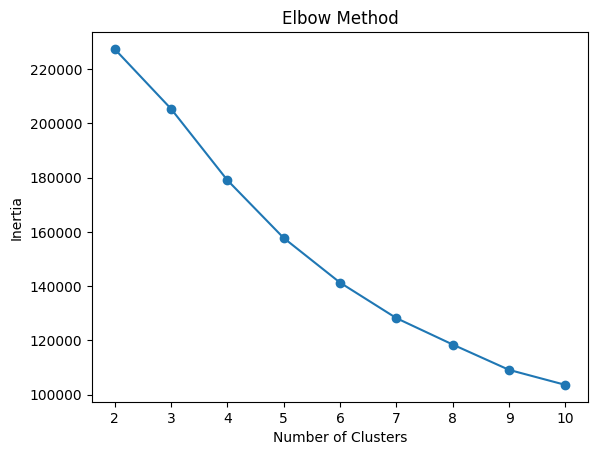

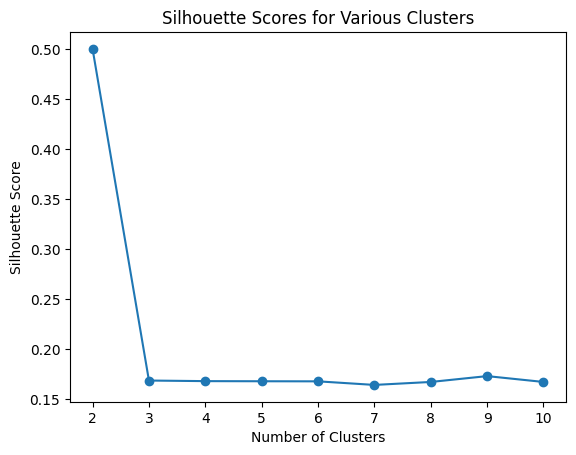

/home/tom/.local/share/virtualenvs/car-following-project-UTHu64Qq/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


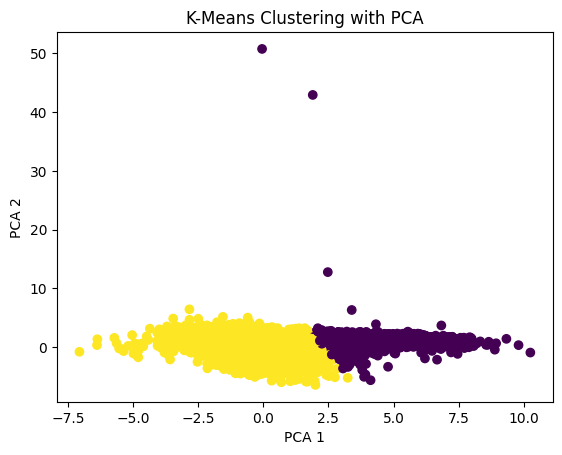

The average silhouette_score is: 0.6774392930539453


In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def normalize_and_cluster(features, n_clusters=3, apply_pca=False):
    """
    Normalize the given feature dataframe, apply PCA if requested,
    and perform KMeans clustering on the data.
    
    Args:
    - features (pd.DataFrame): The dataframe to normalize and cluster.
    - n_clusters (int): Number of clusters.
    - apply_pca (bool): Apply PCA if True.
    
    Returns:
    - tuple: The normalized data, PCA applied data (if requested), and cluster labels.
    """
    # Normalize data
    scaler = StandardScaler()
    features_numeric = features.select_dtypes(include=np.number).dropna()
    normalized_data = scaler.fit_transform(features_numeric)
    
    # Apply PCA
    pca_data = None
    if apply_pca:
        pca = PCA(n_components=2)
        pca_data = pca.fit_transform(normalized_data)
        data_to_cluster = pca_data
    else:
        data_to_cluster = normalized_data
    
    # Perform KMeans Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data_to_cluster)
    features_numeric['cluster'] = labels
    
    return normalized_data, pca_data, labels, features_numeric

def plot_results(features, labels, pca_data=None):
    """
    Plot the results of the KMeans clustering, using PCA data if provided.
    
    Args:
    - features (pd.DataFrame): The feature dataframe.
    - labels (np.array): The cluster labels.
    - pca_data (np.array): The PCA applied data (if PCA was applied).
    """
    if pca_data is not None:
        plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='viridis')
        plt.xlabel('PCA 1')
        plt.ylabel('PCA 2')
        plt.title('K-Means Clustering with PCA')
    else:
        fig = plt.figure(figsize=(15, 7))
        ax1 = fig.add_subplot(121, projection='3d')
        scatter1 = ax1.scatter(features['TTC'], 
                               features['time_headway'], 
                               features['delta_velocity'], 
                               c=labels, 
                               cmap='viridis', 
                               s=50)
        ax1.set_xlabel('TTC')
        ax1.set_ylabel('Time Headway')
        ax1.set_zlabel('Delta Velocity')
        ax1.set_title('K-Means Clustering Results')
        legend1 = ax1.legend(*scatter1.legend_elements(), title="Clusters")
        ax1.add_artist(legend1)
    
    plt.show()

def find_optimal_clusters(data, max_clusters=10):
    """
    Find the optimal number of clusters using the elbow method and silhouette score.
    
    Args:
    - data (np.array): The data to find the optimal clusters for.
    - max_clusters (int): The maximum number of clusters to test.
    
    Returns:
    - int: The optimal number of clusters based on the elbow method and silhouette score.
    """
    inertia_list = []
    silhouette_scores = []
    for n_clusters in range(2, max_clusters+1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(data)
        inertia_list.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, labels))

    # Elbow Method Plot
    plt.plot(range(2, max_clusters+1), inertia_list, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.show()
    
    # Silhouette Score Plot
    plt.plot(range(2, max_clusters+1), silhouette_scores, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores for Various Clusters')
    plt.show()
    
    # Assuming the elbow is at the cluster number with the highest silhouette score
    optimal_clusters = np.argmax(silhouette_scores) + 2  # +2 because range starts from 2
    
    return optimal_clusters

# Usage
selected_features = trainHA  # assuming this is a predefined dataframe

# Finding optimal number of clusters
normalized_data, _, _, _ = normalize_and_cluster(selected_features, apply_pca=True)
optimal_clusters = find_optimal_clusters(normalized_data)

# Clustering and plotting
_, pca_data, labels, clustered_data = normalize_and_cluster(selected_features, n_clusters=optimal_clusters, apply_pca=True)
plot_results(selected_features, labels, pca_data)

# Computing the average silhouette score
silhouette_avg = silhouette_score(pca_data, labels)
print("The average silhouette_score is:", silhouette_avg)


In [10]:
# length of the labels
print(len(labels))# LENGTH OF THE PCA DATA    
print(len(pca_data))
print(len(clustered_data))
clustered_data.head()

26288
26288
26288


,case_id,delta_velocity,v_follower,delta_acceleration,a_follower,jerk_follower,time_headway,delta_position,TTC,TTC_min,cluster
0,0,-0.585128,11.712142,0.047007,2.369844,-0.028677,1.697374,9.428864,61.144338,16.595543,1
1,1,-0.109332,14.526137,0.039523,0.837482,-0.022997,1.499226,18.421163,80.305906,20.562361,1
2,2,-0.717295,13.135771,-0.140948,1.012260,0.010870,3.379581,16.096035,7.636726,5.728496,1
3,3,1.121150,15.083161,0.026782,0.394586,-0.018426,1.937762,22.154348,25.245706,18.166619,1
4,4,0.587793,14.517350,-0.022323,0.667001,-0.018814,2.044764,14.362037,36.424020,7.093686,1


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import math

from src.LSTMModel import LSTMModel

clustered_dataframes = {}
for cluster_number in clustered_data['cluster'].unique():
    clustered_dataframes[cluster_number] = clustered_data[clustered_data['cluster'] == cluster_number].drop(columns=['cluster', 'case_id'])

def preprocess_data(df, n_steps_in, n_steps_out, test_size=0.2):
    scaler = StandardScaler()
    data_normalized = scaler.fit_transform(df)
    X, y = create_sequences(data_normalized, n_steps_in, n_steps_out)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return (
        torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32),
        torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32),
        scaler
    )

def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(data):
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def train_model(model, X_train_tensor, y_train_tensor, epochs, optimizer, loss_function):
    for epoch in tqdm(range(epochs), desc='Training Epochs'):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_tensor)
        loss = loss_function(y_pred, y_train_tensor[:, 0, :])
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            tqdm.write(f'Epoch: {epoch} Loss: {loss.item():.4f}')

def evaluate_model(model, X_test_tensor, y_test_tensor, scaler):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        y_pred = y_pred.cpu().numpy()
        y_pred_original = scaler.inverse_transform(y_pred)
        y_test_original = scaler.inverse_transform(y_test_tensor.cpu().numpy()[:, 0, :])
        mse = mean_squared_error(y_test_original, y_pred_original)
        rmse = math.sqrt(mse)
        mae = mean_absolute_error(y_test_original, y_pred_original)
    print(f'MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}')
    return mse, rmse, mae

models_scalers = {}
n_steps_in, n_steps_out = 3, 1
for cluster, cluster_df in clustered_dataframes.items():
    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, scaler = preprocess_data(cluster_df, n_steps_in, n_steps_out)
    model = LSTMModel(input_size=X_train_tensor.shape[2], hidden_layer_size=50, output_size=y_train_tensor.shape[2])
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_function = nn.MSELoss()
    train_model(model, X_train_tensor, y_train_tensor, epochs=100, optimizer=optimizer, loss_function=loss_function)
    mse, rmse, mae = evaluate_model(model, X_test_tensor, y_test_tensor, scaler)
    models_scalers[cluster] = {'model': model, 'scaler': scaler, 'metrics': (mse, rmse, mae)}

# Save the model and scaler if needed
torch.save(models_scalers, '../models/H_models_scalers.pth')


Training Epochs:   2%|▏         | 2/100 [00:00<00:13,  7.14it/s]

Epoch: 0 Loss: 1.0207


Training Epochs:  12%|█▏        | 12/100 [00:01<00:13,  6.53it/s]

Epoch: 10 Loss: 1.0087


Training Epochs:  22%|██▏       | 22/100 [00:03<00:12,  6.16it/s]

Epoch: 20 Loss: 0.9993


Training Epochs:  32%|███▏      | 32/100 [00:05<00:10,  6.58it/s]

Epoch: 30 Loss: 0.9911


Training Epochs:  42%|████▏     | 42/100 [00:06<00:09,  6.13it/s]

Epoch: 40 Loss: 0.9825


Training Epochs:  52%|█████▏    | 52/100 [00:08<00:07,  6.42it/s]

Epoch: 50 Loss: 0.9736


Training Epochs:  62%|██████▏   | 62/100 [00:09<00:06,  6.23it/s]

Epoch: 60 Loss: 0.9657


Training Epochs:  72%|███████▏  | 72/100 [00:11<00:04,  6.36it/s]

Epoch: 70 Loss: 0.9596


Training Epochs:  82%|████████▏ | 82/100 [00:13<00:02,  6.51it/s]

Epoch: 80 Loss: 0.9554


Training Epochs:  92%|█████████▏| 92/100 [00:14<00:01,  6.63it/s]

Epoch: 90 Loss: 0.9521


Training Epochs: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


MSE: 9420.06, RMSE: 97.06, MAE: 16.17


Training Epochs:  14%|█▍        | 14/100 [00:00<00:00, 139.29it/s]

Epoch: 0 Loss: 1.0694
Epoch: 10 Loss: 1.0627
Epoch: 20 Loss: 1.0587


Training Epochs:  55%|█████▌    | 55/100 [00:00<00:00, 127.02it/s]

Epoch: 30 Loss: 1.0557
Epoch: 40 Loss: 1.0526
Epoch: 50 Loss: 1.0492


Training Epochs:  83%|████████▎ | 83/100 [00:00<00:00, 131.44it/s]

Epoch: 60 Loss: 1.0455
Epoch: 70 Loss: 1.0413
Epoch: 80 Loss: 1.0366


Training Epochs: 100%|██████████| 100/100 [00:00<00:00, 130.27it/s]

Epoch: 90 Loss: 1.0311
MSE: 102532.84, RMSE: 320.21, MAE: 91.32


In [13]:
# Evaluation dataset is used here to predict the next time step
eval_df = convert_df("HA", "val")


data is
        case_id  time    x_leader  x_follower   v_leader  v_follower  \
0             0   0.0    0.000000  -25.147708   9.650530   11.265286   
1             0   0.1    0.965314  -24.020741   9.637913   11.227821   
2             0   0.2    1.927417  -22.919688   9.627554   11.216660   
3             0   0.3    2.888559  -21.803314   9.612102   11.199787   
4             0   0.4    3.846600  -20.687172   9.583392   11.174766   
...         ...   ...         ...         ...        ...         ...   
825824     3054  23.5  165.161579  149.207930   9.843218    7.924927   
825825     3054  23.6  166.152703  150.046628   9.837669    8.044549   
825826     3054  23.7  167.139436  150.914139   9.891022    8.170020   
825827     3054  23.8  168.141800  151.792010  10.036478    8.291918   
825828     3054  23.9  169.155917  152.677066  10.126080    8.408294   

        a_leader  a_follower  l_leader  l_follower  
0      -0.452337   -0.219145      4.85     4.00000  
1      -0.451993   -0

In [14]:
# this is the initial input for the model, the minimum sequence length is 3 so at least 3 rows are needed
eval_df = eval_df.head(3)
eval_df = eval_df.drop(columns=['case_id'])

eval_df


,delta_velocity,v_follower,delta_acceleration,a_follower,jerk_follower,time_headway,delta_position,TTC,TTC_min
0,-0.112306,13.972906,-0.040953,0.913186,0.013031,2.296439,22.095424,124.803687,11.794680
1,1.577983,12.061164,-0.035401,0.162992,0.013574,3.225179,8.866747,18.864220,3.197740
2,-0.274519,12.536280,-0.004253,3.739273,-0.047253,1.156909,9.121510,85.516191,7.427292


In [15]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def preprocess_new_data(new_data, scaler, n_steps_in):
    data_scaled = scaler.transform(new_data)
    X_new = []
    for i in range(len(data_scaled) - n_steps_in + 1):
        X_new.append(data_scaled[i:i + n_steps_in, :])
    return np.array(X_new)

def predict_delta_acceleration(eval_df, models_scalers, cluster_number=1, n_steps_in=3, delta_acceleration_index=2):
    """
    Predicts the delta acceleration of a car using an LSTM model trained on car-following data.

    Parameters:
    eval_df (pandas.DataFrame): The input data to predict on.
    models_scalers (dict): A dictionary containing the trained models and scalers for each cluster.
    cluster_number (int): The cluster number to use for prediction.
    n_steps_in (int): The number of time steps to use as input for the LSTM model.
    delta_acceleration_index (int): The index of the delta acceleration column in the output.

    Returns:
    float: The predicted delta acceleration.
    """
    

    # Load the scaler for the cluster
    scaler = models_scalers[cluster_number]['scaler']

    # Prepare the input data for prediction
    X_new_prepared = preprocess_new_data(eval_df.values, scaler, n_steps_in)
    X_new_tensor = torch.tensor(X_new_prepared, dtype=torch.float32)

    # Load the model for the cluster
    model = models_scalers[cluster_number]['model']

    # Predict using the model
    model.eval()
    with torch.no_grad():
        y_new_pred_tensor = model(X_new_tensor)
        y_new_pred = y_new_pred_tensor.numpy()

    # Inverse transform the predictions to the original scale
    y_new_pred_original = scaler.inverse_transform(y_new_pred)

    # Extract the denormalized delta_acceleration values
    delta_acceleration_pred_original = y_new_pred_original[:, delta_acceleration_index]

    # Return the predicted delta acceleration
    return delta_acceleration_pred_original

# Load the model from the saved models_cales.pth file
models_scalers = torch.load('../models/H_models_scalers.pth')

# Predict the delta acceleration for the eval_df dataframe
cluster_number = 1
delta_acceleration_pred = predict_delta_acceleration(eval_df, models_scalers, cluster_number)
delta_acceleration_pred

/home/tom/.local/share/virtualenvs/car-following-project-UTHu64Qq/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([0.00618792], dtype=float32)